<a href="https://colab.research.google.com/github/dmourlot/FiznzBuzz-ML-Challenge/blob/main/ML_FizzBuzz_CubanEngineer_TechnicalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **INSTRUCTIONS**

Write a program that given the numbers from 1 to 100 print “None” for each number, except for multiples of 3 -- in which case it should print “Fizz”-- and for multiples of 5 --in which case it should print “Buzz”. For multiples of both 3 and 5 it should print “FizzBuzz”.

EXAMPLE:
Entry: [1, 2, 3, 4, 5,..., 15, 16, 18, 19, 20,...]

Result: [None, None, Fizz, None, Buzz,...,FizzBuzz, None, Fizz, None, Buzz,...]

Requirements:
- Train any classification algorithm (E.g. support vector machine ) to solve the test as a classic supervised classification problem with four classes.
- Build your own dataset of any length, any preprocessing step in the input data is allowed.
- Also, provide  the accuracy score obtained by the model with the test data (numbers from 1 - 100).
- Provide a brief theoretical description of the designed model and data pipeline.
- You must  share the implementation and documentation of the project using GitHub.

Extra Points:
- Perform a ten folds cross-validation using  different classification algorithms and select the best among them
- Update the documentation to support the selection (or not) of a new algorithm
- Publish the trained model as a web service 
- Create unit tests for the implementation with a test coverage >=80% 

NOTE: The required theoretical description should be put with the other files from the project, could be in the README or other documentation format. When you finish the test please share the links with us. 

Good luck!

### **Imports**

Here are the core libraries, modules and methods we'll neeed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### **Utility Functions**

Functions we'll be using at various points throughout the solution.

In [2]:
def fizzBuzz(n):
    # Apply the FizzBuzz rule 
    if   n%15 == 0:
        return 'FizzBuzz'
    elif n%3 == 0:
        return 'Fizz'
    elif n%5 == 0:
        return 'Buzz'
    else:
        return 'None'
        
        
def createFizzBuzzData(start, length):
    # Build dataset with numbers from start to (start + length).
    # and shuffle it so they're not ordered
    fb_df = pd.DataFrame({'number': np.arange(start,start + length)})
    fb_df['class'] = fb_df.apply(lambda x: fizzBuzz(x['number']), axis = 1)
    # shuffle data so it is not ordered
    fb_df = fb_df.sample(frac=1)
    return fb_df

def buildBalancedDataset(fb_df):
    # Build a blanced dataset (all classes equally represented)
    
    fb_df_bal = fb_df[fb_df['class'] == 'FizzBuzz']  # initially contains all instances of the least represented class
    no_rows = fb_df_bal['class'].count()
    for c in ['Buzz', 'Fizz', 'None']:
        aux_df = fb_df[fb_df['class'] == c][0:no_rows]
        fb_df_bal = pd.concat([fb_df_bal, aux_df], ignore_index=True)
    # shuffle dataset    
    fb_df_bal = fb_df_bal.sample(frac=1)
    return fb_df_bal

def splitDatasets(df, num_dim):
    # Split train feature(s) from class data
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    # Make 75-25% train-test splits
    X_train, X_cv, y_train, y_cv = train_test_split(x, y, random_state=0)
    
    if num_dim == 1:
        # Reshape as 2D column vectors (avoiding conflicts with sklearn methods)
        X_train = pd.DataFrame(X_train.values.reshape(-1,1))
        X_cv = pd.DataFrame(X_cv.values.reshape(-1,1))
    
    return (X_train, X_cv, y_train, y_cv)

def plotLearningCurve(X, cv_scores, train_scores, title, x_label, y_label):
    # Learning Curve
    plt.plot(X, cv_scores, label = "CV set", linewidth=2)
    plt.plot(X, train_scores, label = "Training set", linewidth=2)
    plt.plot(X, [0.75] * len(X), label = "Min. Expected Perf.", linestyle='dashed', linewidth=1)
    plt.legend(loc = "best")
    
    # Add title and axis names
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def buildPolynomialDataset(X_train, X_cv, degree):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn import preprocessing
    
    poly = PolynomialFeatures(degree = degree)
    # prepare train data
    X_poly = poly.fit_transform(X_train) # add new polynomial features to dataset
    scaler = preprocessing.StandardScaler().fit(X_poly)  # scale data (for LR's optimization algorithm to converge)
    X_poly = scaler.transform(X_poly)
    
    # prepare cv data
    Xcv_poly = poly.fit_transform(X_cv) # add new polynomial features to dataset
    scaler = preprocessing.StandardScaler().fit(Xcv_poly)  # scale data (for LR's optimization algorithm to converge)
    Xcv_poly = scaler.transform(Xcv_poly)
    
    return X_poly, Xcv_poly

def printClassifierMetrics(clf, X_train, X_cv, y_train, y_cv):
    # Print Training and CV metrics for given classifier
    # (Mean Accuracy and Confussion Matrix)
    print(f"Train accuracy: {round(clf.score(X_train, y_train),4)}\n")
    print(f"CV accuracy: {round(clf.score(X_cv, y_cv),4)}\n")
    print("Train Confussion Matrix:")
    y_pred = clf.predict(X_train)
    # Prettify confussion matrix presentation
    cm_df = pd.DataFrame(confusion_matrix(y_train, y_pred))
    cm_df.columns = clf.classes_
    cm_df.set_index(clf.classes_, inplace = True)
    
    print(cm_df)

def binaryEncode(i, num_bits):
    # Convert an integer to its binary equivalent using numb_bits
    return np.array([i >> d & 1 for d in range(num_bits)])

def buildBinaryDataset(fb_df, length, num_bits):
    # Binary encode each integer in our dataset. Return a 
    # dataframe with each column representing a bit position 
    bin_matrix = np.zeros([length,num_bits])
    for n, i in zip(fb_df['number'],range(length)):
        bin_matrix[i] = binaryEncode(n,num_bits)
    bin_df = pd.DataFrame(bin_matrix).astype('int32') # create DF from numpy ndarray
    bin_df = pd.concat([bin_df, fb_df['class'].reset_index(drop=True)], axis = 1) # add class column to binary dataset
    return bin_df

### **Key Initializations**

First of all, let's generate our hold-out or test set with numbers from 1 to 100. Models will only see this dataset at prediction time

In [4]:
# Generate hold-out/test dataset with numbers 1 through 100
start = 1     
length = 100       
hold_df = createFizzBuzzData(start, length).sort_values(['number'])

# Make features vs class split
X_hold = hold_df['number']
y_hold = hold_df['class']

#print(X_hold.head)
#print(y_hold.head)

Let us also initialize the `start` variable at `101`, to ensure there's no data leakage (i.e cheating). No generated training set may contain elements from the hold-out/test set.

In [5]:
start = 101

Generate initial dataset:
Use relatively few instances just to prove our "quick'n dirty solution".

In [6]:
length = 5000     # number of training instances  
fb_df = createFizzBuzzData(start, length)
print(fb_df.shape)
fb_df.head

(5000, 2)


<bound method NDFrame.head of       number class
4619    4720  Buzz
873      974  None
2049    2150  Buzz
867      968  None
1060    1161  Fizz
...      ...   ...
1388    1489  None
537      638  None
3376    3477  Fizz
1251    1352  None
2731    2832  Fizz

[5000 rows x 2 columns]>

### **Some (very basic) Exploratory Data Analysis**

Since we're just working with a succession of continous, non-repeated positive integers, there's no point really in computing statistics such as  mean, standard deviation and the like. Analysis of distributions, with histograms and the like, don't make much sense either. 

However, we can gain some insight from examining class distributions: 

In [7]:
fb_df['class'].describe()

count     5000
unique       4
top       None
freq      2667
Name: class, dtype: object

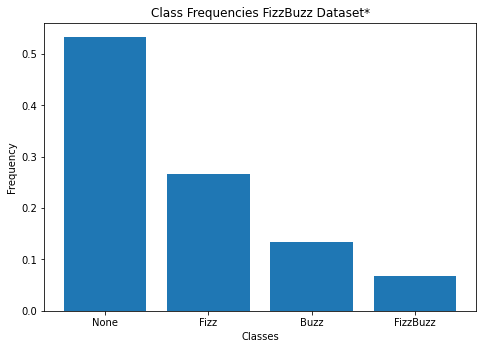

In [8]:
# Plot a bar chart with class frequencies
pct = fb_df['class'].value_counts()/length

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pct.index,pct)
ax.set_title('Class Frequencies FizzBuzz Dataset*')
ax.set_ylabel('Frequency')
ax.set_xlabel('Classes')
plt.show()

**NOTE: It turns out that class frequencies remain the same as long as we keep the number of instances in our dataset a multiple of 100*.

As we can see, class `None` is over represented, while classes `Buzz` and (specially) `FizzBuzz` are under represented. Could this have a negative impact on performance?

### **"Quick n dirty" solution: Logistic Regression**

It is considered good practice to work first in a 'quick n dirty' solution to our problem; using this simple model to spot things like bias and/or variance issues. From there, we can more confidently move (if necessary) to different feature engineering techniques, more complex algorithms, models and pipelines, etc.

In this case, our choice will be Logistic Regression with default parameter values, and no feature engineering steps.

In [9]:
from sklearn.linear_model import LogisticRegression

X_train, X_cv, y_train, y_cv = splitDatasets(fb_df, 1)
lr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
printClassifierMetrics(lr_clf, X_train, X_cv, y_train, y_cv)

Train accuracy: 0.5219

CV accuracy: 0.568

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz  None
Buzz         0     0         0   534
Fizz         0     0         0  1007
FizzBuzz     0     0         0   252
None         0     0         0  1957


Very poor performance!! LR is behaving exactly as a "predict most frequent" dummy classifier.

In [11]:
from sklearn.dummy import DummyClassifier

X_train, X_cv, y_train, y_cv = splitDatasets(fb_df, 1)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
printClassifierMetrics(dummy_clf, X_train, X_cv, y_train, y_cv)

Train accuracy: 0.5219

CV accuracy: 0.568

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz  None
Buzz         0     0         0   534
Fizz         0     0         0  1007
FizzBuzz     0     0         0   252
None         0     0         0  1957


In some cases an inbalanced dataset (with some classes under represented) can impair model's performance. Let's try with a balanced version and see if it helps...

In [13]:
# Build balanced dataset
fb_df_bal = buildBalancedDataset(fb_df)

#print(fb_df_bal['class'].describe())
aux = fb_df_bal['class'].value_counts()
print("Class counts:\n")
print(aux,'\n')
pct = aux.iloc[:]/fb_df_bal['class'].count()

X_train_bal, X_cv_bal, y_train_bal, y_cv_bal = splitDatasets(fb_df_bal, 1)
lr_clf = LogisticRegression(random_state=0).fit(X_train_bal, y_train_bal)
printClassifierMetrics(lr_clf, X_train_bal, X_cv_bal, y_train_bal, y_cv_bal)

Class counts:

Buzz        334
None        334
FizzBuzz    334
Fizz        334
Name: class, dtype: int64 

Train accuracy: 0.2575

CV accuracy: 0.2275

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz  None
Buzz         0     0       254     0
Fizz         0     0       238     0
FizzBuzz     0     0       258     0
None         0     0       252     0


Much worse results (even when predicting on same data used in training)!! Balancing class representations doesn't seem to help at all.

#### *BIAS vs VARIANCE Analysis*

Let's run some tests to see if we have problems with high bias (underfitting) or high variance (overfitting).

Lets see what's our LR model performance on training and CV sets as we increase the number of training instances...  

Train accuracies: [0.5328, 0.5369, 0.5318, 0.5363, 0.5347, 0.536, 0.5286, 0.5329, 0.5298, 0.5354, 0.5348, 0.5325, 0.534, 0.5297, 0.5324, 0.5335, 0.5346, 0.5325, 0.5319, 0.535]

CV accuracies: [0.5352, 0.5227, 0.5383, 0.5245, 0.5293, 0.5256, 0.5476, 0.5347, 0.544, 0.5271, 0.5288, 0.536, 0.5315, 0.5442, 0.5364, 0.533, 0.5295, 0.536, 0.5377, 0.5283]



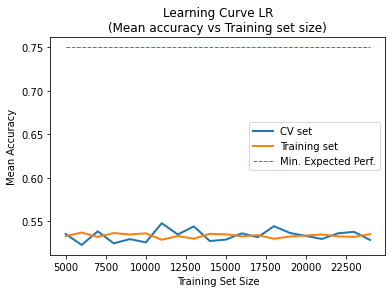

In [23]:
cv_scores = []
train_scores = []
sets_sizes = np.arange(5000,25000, 1000)
 
lr_clf = LogisticRegression(random_state=0)
for l in sets_sizes:
    fb_df = createFizzBuzzData(start, l) # create dataset of new length l
    X_train, X_cv, y_train, y_cv = splitDatasets(fb_df, 1) # create splits for training and cross validation sets
    clf = lr_clf.fit(X_train, y_train)
    cv_scores.append(clf.score(X_cv, y_cv))
    train_scores.append(clf.score(X_train, y_train))

print(f"Train accuracies: {[round(a,4) for a in train_scores]}\n")
print(f"CV accuracies: {[round(a,4) for a in cv_scores]}\n")
plotLearningCurve(sets_sizes, cv_scores, train_scores, 'Learning Curve LR\n(Mean accuracy vs Training set size)','Training Set Size', 'Mean Accuracy')

We see that adding more training examples is not helping boost model performance in the slightest. This learning curve -with low mean accuracies on both Train and CV datasets- is a clear indicator that we're confronting a  high bias (underfitting) problem --since (not surprinsingly) our one-variable LR model is too simple to fit (find) the underlying relationships in data. And, of course, adding more training examples do not help overcome underfitting.

Let's see if we can improve performance by adding complexity (i.e polynomial features) to our model.

(5000, 2)
Train accuracies: [0.536, 0.536, 0.536, 0.536, 0.536]

CV accuracies: [0.5256, 0.5256, 0.5256, 0.5256, 0.5256]



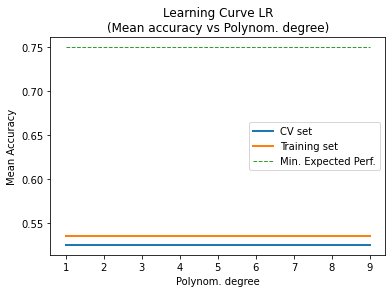

In [22]:
degrees = np.arange(1,10,2)
cv_scores = []
train_scores = []

length = 5000
fb_df = createFizzBuzzData(start, length)
X_train, X_cv, y_train, y_cv = splitDatasets(fb_df,1) # create splits for training and cross validation sets

lr_clf = LogisticRegression(random_state=0, max_iter = 10000)
for d in degrees:
    #prepare train and cv data
    X_poly, Xcv_poly = buildPolynomialDataset(X_train, X_cv, d)
    # train model with new polynomial features
    clf = lr_clf.fit(X_poly, y_train)
    cv_scores.append(clf.score(Xcv_poly, y_cv))
    train_scores.append(clf.score(X_poly, y_train))

print(f"Train accuracies: {[round(a,4) for a in train_scores]}\n")
print(f"CV accuracies: {[round(a,4) for a in cv_scores]}\n")
plotLearningCurve(degrees, cv_scores, train_scores,'Learning Curve LR\n(Mean accuracy vs Polynom. degree)', 'Polynom. degree', 'Mean Accuracy')

Both Training and CV mean accuracies stay exactly the same no matter how many polynomial variables we add (puzzling, but true!). Even though we observe a slight increase in CV mean accuracy, it is still far from good. So we must conclude that Logistic Regression is not a good choice for this problem. We need something more complex. 

### **Support Vector Machine**

Since Logistic Regression proved too simple for this problem, let's try something more advanced, like a SVM algorithm, and see if we can overcome our high variance problems.

In [24]:
from sklearn.svm import SVC  
from sklearn.preprocessing import MinMaxScaler

Test SVM with one-variable dataset...

In [29]:
# Generate dataset 
length = 10000     # number of training instances  
fb_df = createFizzBuzzData(start, length)
X_train, X_cv, y_train, y_cv = splitDatasets(fb_df,1) # create splits for training and cross validation sets

# SVMs benefit from feature scaling/normalization
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)

norm = MinMaxScaler().fit(X_cv)
X_cv_norm = norm.transform(X_cv)

In [30]:
svm_clf = SVC(kernel = 'rbf', gamma='auto').fit(X_train_norm, y_train)
printClassifierMetrics(svm_clf, X_train_norm, X_cv_norm, y_train, y_cv)

Train accuracy: 0.5345

CV accuracy: 0.53

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz  None
Buzz         0     0         0  1004
Fizz         0     0         0  1975
FizzBuzz     0     0         0   512
None         0     0         0  4009


Here we show several SVM results for different parameter configurations (with Dataset size = 20 000, normalization =  MinMaxScaling)

- (kernel = "rbf", gamma = "scale"): Train accuracy: 0.5335, CV accuracy: 0.5328

- (kernel = "rbf", gamma = "auto"): Train accuracy: 0.5335, CV accuracy: 0.5328

- (kernel = "rbf", gamma = "auto", class_weight = "balanced"): Train accuracy: 0.1996, CV accuracy: 0.1864

- (kernel = "sigmoid", gamma = scale): Train accuracy: 0.3655, CV accuracy: 0.3702

- (kernel = "sigmoid", gamma = "auto"): Train accuracy: 0.4079, CV accuracy: 0.392

Results are mediocre -to say the least. They clearly show that even SVM algorithm isn't complex enough to accurately model this particular problem. 

### **Neural Networks**

So, SVM didn't move the needle either. I guess, it's time to bring out the big guns...

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
def generateMLPDataset(start, length):
    # Generate FizzBuzz dataset
    fb_df = createFizzBuzzData(start, length) 
    # Binary encode FizzBuzz dataset 
    # (Neural Networks greatly benefit from a binary encoding)
    num_digits = fb_df['number'].max().bit_length() # returns the total number of bits required to binary encode any integer
    fb_df_bin = buildBinaryDataset(fb_df, length, num_digits) # binary encode FizzBuzz dataset
    
    return fb_df_bin


Let's test `MLP` classifier with a dataset of only 1000 instances and a basic configuration of only one hidden layer, with 100 units in it, using the `relu` acitvation function along with the `adam` solver.*

**See sklearn documentation for parameter descriptions (activation functions, solvers, etc.) https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html*

In [31]:
# Generate FizzBuzz dataset
length = 1000     # number of training instances
fb_df_bin = generateMLPDataset(start, length) # binary encode FizzBuzz dataset
X_bin_train, X_bin_cv, y_train, y_cv = splitDatasets(fb_df_bin,len(fb_df_bin.columns)-1) # create splits for training and cross validation sets
mlp_clf = MLPClassifier(hidden_layer_sizes = (100,), solver = 'adam', random_state=1, max_iter=10000).fit(X_bin_train, y_train)

printClassifierMetrics(mlp_clf, X_bin_train, X_bin_cv, y_train, y_cv )

Train accuracy: 1.0

CV accuracy: 0.836

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz  None
Buzz       104     0         0     0
Fizz         0   201         0     0
FizzBuzz     0     0        45     0
None         0     0         0   400


Good! The Neural Network (`MLP`) model seems to be complex enough to solve our High Bias problem -evidenced in the remarkable increase in CV accuracy. However, at least with current parameters and train size (1000 instances), we observe signs of high variance/overfitting (i.e perfect performance on training set, but unable to fully generalize for unseen instances in CV dataset). We have a couple of options to correct this:

Let's start by the obvious one: increasing training size...

*NOTE: The following piece of code took me a lot of time to complete (10+ minutes) even using Gooogle's Colab.*

In [36]:
cv_scores = []     # Will hold classifier's CV mean accuracy on each of the different runs  
train_scores = []  # Will hold classifier's Train mean accuracy on each of the different runs
set_sizes = np.arange(5000,31000, 5000)   # list of data set sizes increasing by 5 000

mlp_clf = MLPClassifier(hidden_layer_sizes = (100,), solver = 'adam', random_state=1, max_iter=10000)
for l in set_sizes:
    fb_df = createFizzBuzzData(start, l) # create dataset of new length l
    fb_df_bin = generateMLPDataset(start, l) # binary encode FizzBuzz dataset
    X_bin_train, X_bin_cv, y_train, y_cv = splitDatasets(fb_df_bin,len(fb_df_bin.columns)-1) # create splits for training and cross validation sets
    clf = mlp_clf.fit(X_bin_train, y_train)
    cv_scores.append(clf.score(X_bin_cv, y_cv))
    train_scores.append(clf.score(X_bin_train, y_train))   


Train accuracies: [0.9968, 0.9879, 0.9968, 0.9761, 0.9973, 0.9916]

CV accuracies: [0.9424, 0.9444, 0.9779, 0.9604, 0.9888, 0.9839]



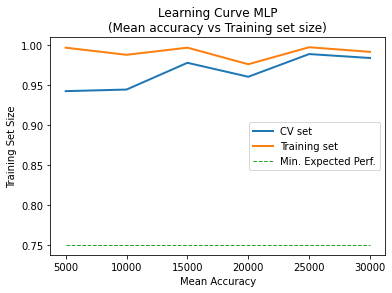

In [37]:
print(f"Train accuracies: {[round(a,4) for a in train_scores]}\n")
print(f"CV accuracies: {[round(a,4) for a in cv_scores]}\n")
plotLearningCurve(set_sizes, cv_scores, train_scores, 'Learning Curve MLP\n(Mean accuracy vs Training set size)','Mean Accuracy','Training Set Size')

Voila❗

As it turns out, increasing training size largely solves the high variance (overfitting) problem of our first MLP model. We can see that best performance is reached at around 25 000 examples. 

So, lets retrain our `MLP` classifier with 30 000 examples (since we have the privilege of unlimited data), and  use it as our definite FizzBuzz challenge solver. But first lets twick the regularization parameter `alpha` just a bit -hoping to gain a little more generalization power.

In [82]:
from sklearn.model_selection import cross_val_score

# train model with 30000 examples and a higher alpha value (more regularization)
mlp_clf = MLPClassifier(hidden_layer_sizes = (100,), solver = 'adam', alpha = 0.01, random_state=1, max_iter=10000).fit(X_bin_train, y_train) 

printClassifierMetrics(mlp_clf, X_bin_train, X_bin_cv, y_train, y_cv )

Train accuracy: 0.9922

CV accuracy: 0.9847

Train Confussion Matrix:
          Buzz  Fizz  FizzBuzz   None
Buzz      2974     8         0     49
Fizz         2  5949         2     60
FizzBuzz     1     0      1480     15
None        13    26         0  11921


Finally let's evaluate the model using `cross_val_score` to have a better idea of what to expect when we finally attempt to solve the FizzBuzz challenge using our trained `MLP` model.

**NOTE: Cross validation is time expensive (and we don't really need it in this case), but we'll use it anyway. We will set it to just 5-fold to economize time.*

In [83]:
scores = cross_val_score(mlp_clf, fb_df_bin.iloc[:,:-1], fb_df_bin.iloc[:,-1], cv=5)  # only 5-fold cross validation for it hinders performance

In [84]:
print(scores)
print(scores.mean())

[0.9875     0.9885     0.98316667 0.97133333 0.99433333]
0.9849666666666665


### **Prediction**

So, the moment of truth has arrived. It's time for us to use our model and predict FizzBuzz classes for every number from 1-100.

But first, some preprocessing steps to accomodate the hold-out dataset to our MLP model:

In [51]:
# Binary encode hold-out dataset (numbers 1-100)
# (we must encode with the same number of digits used in training, since this
# is also the number of nodes in the input layer of our MLP classifier)
num_digits = int(start + fb_df_bin.iloc[:,0].count()).bit_length()
hold_df_bin = buildBinaryDataset(hold_df, 100, num_digits)  #this line for Colab

In [52]:
hold_df_bin.head

<bound method NDFrame.head of     0  1  2  3  4  5  6  7  8  9  10  11  12  13  14 class
0   1  0  0  0  0  0  0  0  0  0   0   0   0   0   0  None
1   0  1  0  0  0  0  0  0  0  0   0   0   0   0   0  None
2   1  1  0  0  0  0  0  0  0  0   0   0   0   0   0  Fizz
3   0  0  1  0  0  0  0  0  0  0   0   0   0   0   0  None
4   1  0  1  0  0  0  0  0  0  0   0   0   0   0   0  Buzz
.. .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..   ...
95  0  0  0  0  0  1  1  0  0  0   0   0   0   0   0  Fizz
96  1  0  0  0  0  1  1  0  0  0   0   0   0   0   0  None
97  0  1  0  0  0  1  1  0  0  0   0   0   0   0   0  None
98  1  1  0  0  0  1  1  0  0  0   0   0   0   0   0  Fizz
99  0  0  1  0  0  1  1  0  0  0   0   0   0   0   0  Buzz

[100 rows x 16 columns]>

In [53]:
# Split hold-out dataset into features and class
X_hold_bin = hold_df_bin.iloc[:,:-1]
y_hold = hold_df_bin.iloc[:,-1]

In [55]:
X_hold_bin.head

<bound method NDFrame.head of     0  1  2  3  4  5  6  7  8  9  10  11  12  13  14
0   1  0  0  0  0  0  0  0  0  0   0   0   0   0   0
1   0  1  0  0  0  0  0  0  0  0   0   0   0   0   0
2   1  1  0  0  0  0  0  0  0  0   0   0   0   0   0
3   0  0  1  0  0  0  0  0  0  0   0   0   0   0   0
4   1  0  1  0  0  0  0  0  0  0   0   0   0   0   0
.. .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..
95  0  0  0  0  0  1  1  0  0  0   0   0   0   0   0
96  1  0  0  0  0  1  1  0  0  0   0   0   0   0   0
97  0  1  0  0  0  1  1  0  0  0   0   0   0   0   0
98  1  1  0  0  0  1  1  0  0  0   0   0   0   0   0
99  0  0  1  0  0  1  1  0  0  0   0   0   0   0   0

[100 rows x 15 columns]>

In [56]:
y_hold .head

<bound method NDFrame.head of 0     None
1     None
2     Fizz
3     None
4     Buzz
      ... 
95    Fizz
96    None
97    None
98    Fizz
99    Buzz
Name: class, Length: 100, dtype: object>

Without further ado, let's find out what our model can do.... (Cross your fingers!)

In [85]:
# test model accuracy on hold-out/test set
print(f"Accuracy on test set (numbers from 1 to 100): {mlp_clf.score(X_hold_bin, y_hold)}\n")

print("Confussion Matrix:")
y_pred = mlp_clf.predict(X_hold_bin)
cm_df = pd.DataFrame(confusion_matrix(y_hold, y_pred))
cm_df.columns = clf.classes_
cm_df.set_index(clf.classes_, inplace = True)
cm_df

Accuracy on test set (numbers from 1 to 100): 1.0

Confussion Matrix:


,Buzz,Fizz,FizzBuzz,None
Buzz,14,0,0,0
Fizz,0,27,0,0
FizzBuzz,0,0,6,0
None,0,0,0,53


Check if it got any numbers wrong, and which ones:

In [88]:
misclass = X_hold[y_pred != y_hold].to_list()
print(f"Misclassified numbers: {misclass}")
print(f"Total: {len(misclass)}")

Misclassified numbers: []
Total: 0
